## K-Fold on SVM, Random forest


In [1]:
import pickle
from sklearn import preprocessing
from nltk import word_tokenize
import string
import csv 
from sklearn.model_selection import KFold
from sklearn import svm
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, f1_score
#from imblearn.over_sampling import SMOTENC, SMOTEN, RandomOverSampler
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle



In [2]:
text = []
labels = []
with open("../AllData/appended_dataset_placeholders.csv", newline="") as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        text.append(row[0].strip())
        labels.append(row[1].strip())


In [3]:
punctuation= string.punctuation
punctuation = punctuation.replace('?', '')
punctuation = punctuation.replace("'", '')
punctuation = punctuation.replace('{', "")
punctuation = punctuation.replace("}", "")
punctuation = punctuation.replace("*", "")

## Get the vocab and encode the data 

In [4]:
vocab = []
X_tokens =[]
X_text = []
for t in text: 
    #Converting to lowercase
    t = t.lower()
    #tokenizing the text 
    t = word_tokenize(t)
    #Tokenizing text and removing punctuation at the same time
    new_text = [i for i in t if i not in punctuation]
    X_text.append(" ".join(new_text).strip())
    X_tokens.append(new_text)
    for n in new_text:
        if n not in vocab: 
            vocab.append(n)

In [5]:
vocab.append("<UNK>")
len(vocab) 

1306

In [11]:
#One-hot encoding the text: feature vector length is the length of the vocab
X_encoded =[]
for x in X_tokens:
    encoded= [0]*len(vocab)
    for t in x: 
        if t in vocab: 
            encoded[vocab.index(t)]= 1
        else:
            encoded[vocab.index("<UNK>")] =1
    X_encoded.append(encoded)

In [12]:
le = preprocessing.LabelEncoder()
le.fit(labels)

#the 13 classes as recognized by the label encoder
classes= list(le.classes_)
print(classes)

y_encoded = le.transform(labels)
#Label for the first class 
print("Class: ", labels[0])
#print("Class_encoded: ", y_encoded[0])

['ack', 'dno', 'fa', 'fe', 'fp', 'ft', 'n', 'n-d', 'query', 'sno', 'so', 'y', 'y-d']
Class:  ack


## Kfold when still text

In [13]:
data_before_kfold = [list(i) for i in list(zip(X_text, labels))]
kfold = KFold(n_splits=5, shuffle=True, random_state=47)
data_after_kfold = kfold.split(data_before_kfold)


## Get the best parameters for SVM


In [47]:
svc = svm.SVC()

In [48]:
parameters = {"kernel": ("linear", "rbf"), "C": list(range(10,110, 10))}
print(parameters)

{'kernel': ('linear', 'rbf'), 'C': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}


In [49]:
svm_rnd_search = RandomizedSearchCV(svc, parameters, n_iter =20, cv=kfold)
svm_rnd_search.fit(X_encoded,y_encoded)

print(svm_rnd_search.best_params_, svm_rnd_search.best_score_)


{'kernel': 'rbf', 'C': 10} 0.8197517342095656


In [50]:
best_params = svm_rnd_search.best_params_
best_params

{'kernel': 'rbf', 'C': 10}

In [51]:
#rnd_search.cv_results_


## Get the data

In [52]:
#kfold_split_data = [] 
#models = []

data_train= [] #To save to use for BERT
data_train_encoded=[]
data_test = []
data_test_encoded =[]
for train, test in data_after_kfold:
    train_decoded = [data_before_kfold[i] for i in train]
    test_decoded = [data_before_kfold[i] for i in test]
    X_train = [i[0] for i in train_decoded ]
    y_train = [i[1] for i in train_decoded ]
    #print(y_train)
    
    X_train_encoded=[X_encoded[i] for i in train]
    y_train_encoded = le.transform(y_train)
    data_train.append([X_train,y_train])
    data_train_encoded.append([X_train_encoded, y_train_encoded])
    
    print(len(Counter(y_train)))
    
    print("Distribution", Counter(y_train))
    X_test = [i[0] for i in test_decoded]
    y_test = [i[1] for i in test_decoded]
    print(len(Counter(y_test)))
    
    X_test_encoded = [ X_encoded[i] for i in test]
    y_test_encoded = le.transform(y_test)
    
    data_test.append([X_test,y_test])
    data_test_encoded.append([X_test_encoded, y_test_encoded])
    
    print("Distribution", Counter(y_test))


## Saving the KFold data Splits for BERT

In [53]:
"""for i in range(5):
    with open("../FinalBERT/Data/split_train_"+str(i)+".csv", "w", newline='') as csvf:
        writer = csv.writer(csvf, delimiter=',')
        writer.writerow(["text", "label"])
        for l in range(len(data_train[i][0])):
            writer.writerow([data_train[i][0][l], data_train_encoded[i][1][l]])
            
    with open("../FinalBERT/Data/split_test_"+str(i)+".csv", "w", newline='') as csvf:
        writer = csv.writer(csvf, delimiter=',')
        writer.writerow(["text", "label"])
        for l in range(len(data_test[i][0])):
            writer.writerow([data_test[i][0][l], data_test_encoded[i][1][l]])"""

'for i in range(5):\n    with open("../FinalBERT/Data/split_train_"+str(i)+".csv", "w", newline=\'\') as csvf:\n        writer = csv.writer(csvf, delimiter=\',\')\n        writer.writerow(["text", "label"])\n        for l in range(len(data_train[i][0])):\n            writer.writerow([data_train[i][0][l], data_train_encoded[i][1][l]])\n            \n    with open("../FinalBERT/Data/split_test_"+str(i)+".csv", "w", newline=\'\') as csvf:\n        writer = csv.writer(csvf, delimiter=\',\')\n        writer.writerow(["text", "label"])\n        for l in range(len(data_test[i][0])):\n            writer.writerow([data_test[i][0][l], data_test_encoded[i][1][l]])'

#### Best params from the paper to reproduce the same results 

In [54]:
#Comment out when not needed
best_params = {'kernel': 'rbf', 'C': 10} 

## SVM 


-------------------------------Model 0--------------------------------


c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ack       1.00      0.67      0.80         3
         dno       1.00      0.80      0.89         5
          fa       1.00      1.00      1.00         6
          fe       1.00      0.62      0.76        13
          fp       0.89      0.89      0.89         9
          ft       1.00      0.90      0.95        10
           n       0.81      1.00      0.90        13
         n-d       0.00      0.00      0.00         2
       query       0.80      1.00      0.89         4
         sno       0.82      0.96      0.89        83
          so       1.00      0.20      0.33         5
           y       0.89      1.00      0.94         8
         y-d       0.00      0.00      0.00         5

    accuracy                           0.86       166
   macro avg       0.79      0.69      0.71       166
weighted avg       0.84      0.86      0.83       166

-------------------------------Model 1--------------------------------


c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ack       0.00      0.00      0.00         1
         dno       1.00      0.50      0.67         6
          fa       1.00      0.90      0.95        10
          fe       1.00      0.73      0.84        11
          fp       0.87      0.87      0.87        15
          ft       1.00      1.00      1.00         6
           n       0.91      1.00      0.95        10
         n-d       0.00      0.00      0.00         2
       query       1.00      0.80      0.89         5
         sno       0.81      0.96      0.88        81
          so       1.00      0.17      0.29         6
           y       0.67      1.00      0.80         8
         y-d       0.00      0.00      0.00         5

    accuracy                           0.84       166
   macro avg       0.71      0.61      0.63       166
weighted avg       0.83      0.84      0.81       166

-------------------------------Model 2--------------------------------


c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ack       1.00      1.00      1.00         1
         dno       1.00      0.71      0.83        14
          fa       1.00      0.83      0.91        12
          fe       1.00      0.73      0.84        11
          fp       0.79      0.85      0.81        13
          ft       0.89      1.00      0.94         8
           n       1.00      0.89      0.94         9
         n-d       0.00      0.00      0.00         1
       query       0.86      0.86      0.86         7
         sno       0.80      0.96      0.87        73
          so       0.67      0.50      0.57         4
           y       1.00      0.60      0.75        10
         y-d       0.00      0.00      0.00         2

    accuracy                           0.85       165
   macro avg       0.77      0.69      0.72       165
weighted avg       0.85      0.85      0.84       165

-------------------------------Model 3--------------------------------


c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ack       1.00      0.20      0.33         5
         dno       0.88      0.78      0.82         9
          fa       1.00      0.80      0.89         5
          fe       0.75      0.75      0.75         8
          fp       0.55      0.60      0.57        10
          ft       1.00      1.00      1.00         8
           n       0.55      0.86      0.67         7
         n-d       0.00      0.00      0.00         3
       query       0.78      0.70      0.74        10
         sno       0.75      0.91      0.82        75
          so       0.00      0.00      0.00         7
           y       1.00      0.79      0.88        14
         y-d       1.00      0.25      0.40         4

    accuracy                           0.76       165
   macro avg       0.71      0.59      0.61       165
weighted avg       0.75      0.76      0.73       165

-------------------------------Model 4--------------------------------


c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ack       1.00      0.33      0.50         3
         dno       1.00      0.70      0.82        10
          fa       1.00      0.78      0.88         9
          fe       0.67      0.60      0.63        10
          fp       0.92      0.75      0.83        16
          ft       0.90      1.00      0.95         9
           n       1.00      0.80      0.89        10
         n-d       0.00      0.00      0.00         2
       query       0.83      0.62      0.71         8
         sno       0.71      0.97      0.82        69
          so       0.00      0.00      0.00         8
           y       0.89      0.80      0.84        10
         y-d       0.00      0.00      0.00         1

    accuracy                           0.79       165
   macro avg       0.69      0.57      0.61       165
weighted avg       0.77      0.79      0.76       165



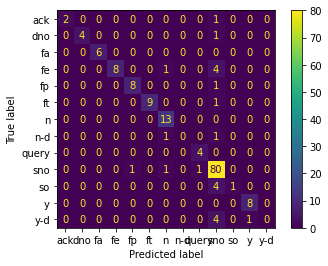

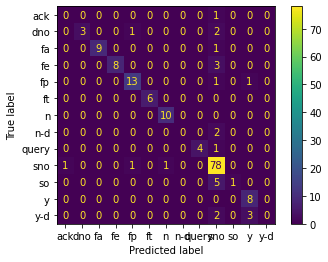

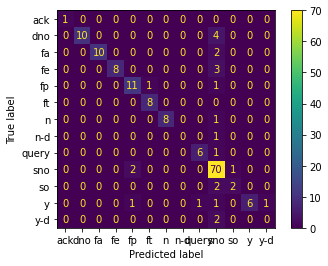

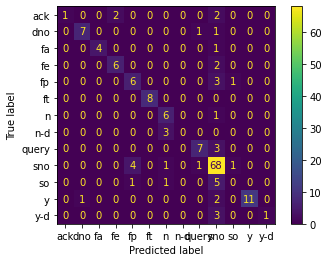

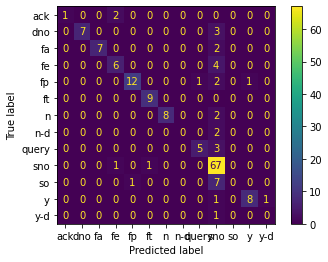

In [24]:
models = []
predictions =[]
scores = []
f1_scores = []
for i in range(len(data_train_encoded)):
    print("-------------------------------Model "+ str(i)+"--------------------------------")
    training_data = data_train_encoded[i]
    X_train_en = training_data[0]
    #print(len(X_train_en))
    y_train_en = training_data[1]
    #print(len(X_test_en))
    test_data = data_test_encoded[i]
    X_test_en = test_data[0]
    #print("X_test", len(X_test_en))
    y_test_en = test_data[1]
    #print(len(y_test_en))
    
    svc = svm.SVC(kernel=best_params['kernel'], C=best_params['C'])
    svc.fit(X_train_en, y_train_en)
    models.append(svc)
    #print("X_test:", len(X_test_en))
    y_pred = svc.predict(X_test_en)
    #print(len(y_pred))
    predictions.append(y_pred)
    scores.append(accuracy_score(y_test_en, y_pred))
    f1_scores.append(f1_score(y_test_en, y_pred,average='macro'))
    print(classification_report(le.inverse_transform(y_test_en), le.inverse_transform(y_pred)))
    print("-------------------------------Model "+ str(i)+"--------------------------------")

    cm = confusion_matrix(le.inverse_transform(y_test_en), le.inverse_transform(y_pred))    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot()
    

In [25]:
scores

[0.8614457831325302,
 0.8433734939759037,
 0.8484848484848485,
 0.7575757575757576,
 0.7878787878787878]

In [26]:
f1_scores

[0.71045309742865,
 0.6254728520562598,
 0.7176795313489349,
 0.605382006598389,
 0.6055714417681046]

In [27]:
sum(scores)/5

0.8197517342095656

In [28]:
sum(f1_scores)/5

0.6529117858400677

## Random Forest

In [29]:
#from sklearn.model_selection import RandomizedSearchCV
import numpy as np
# Number of trees in random forest
n_estimators = [x for x in range(10, 200, 10)]
# Number of features to consider at every split
max_features = ('auto', 'sqrt')
# Maximum number of levels in tree
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]
# Minimum number of samples required to split a node
min_samples_split = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = (True, False)
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [30]:
random_grid

{'n_estimators': [10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190],
 'max_features': ('auto', 'sqrt'),
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': (True, False)}

In [31]:
rf_clf = RandomForestClassifier()
rnd_search = RandomizedSearchCV(rf_clf, random_grid, n_iter =50, cv=kfold)
rnd_search.fit(X_encoded,y_encoded)



c:\users\adianidm\venv\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\adianidm\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\adianidm\venv\lib\site-packages\sklearn\ensemble\_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "c:\users\adianidm\venv\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\users\adianidm\venv\lib\site-packages\

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=47, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'bootstrap': (True, False),
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ('auto', 'sqrt'),
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         120, 130, 140, 150,
                                         

In [32]:
rf_best_params = rnd_search.best_params_
rf_best_score = rnd_search.best_score_

In [33]:
print("Best_params", rf_best_params)
print("Best_score", rf_best_score)

Best_params {'n_estimators': 180, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 110, 'bootstrap': False}
Best_score 0.7956115370573202


In [55]:
#rnd_search.cv_results_

#### Best params from the paper to reproduce the same results 

In [40]:
## Comment out when not needed
rf_best_params = {'n_estimators': 190, 
               'min_samples_split': 10, 
               'min_samples_leaf': 1, 
               'max_features': 'sqrt', 
               'max_depth': 70, 
               'bootstrap': False}

c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ack       1.00      0.33      0.50         3
         dno       0.80      0.80      0.80         5
          fa       1.00      0.83      0.91         6
          fe       1.00      0.62      0.76        13
          fp       0.88      0.78      0.82         9
          ft       1.00      0.80      0.89        10
           n       0.83      0.77      0.80        13
         n-d       0.00      0.00      0.00         2
       query       0.75      0.75      0.75         4
         sno       0.75      0.96      0.85        83
          so       0.00      0.00      0.00         5
           y       0.89      1.00      0.94         8
         y-d       0.00      0.00      0.00         5

    accuracy                           0.81       166
   macro avg       0.68      0.59      0.62       166
weighted avg       0.77      0.81      0.77       166



c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ack       0.00      0.00      0.00         1
         dno       0.60      0.50      0.55         6
          fa       1.00      0.60      0.75        10
          fe       0.80      0.73      0.76        11
          fp       1.00      0.80      0.89        15
          ft       1.00      1.00      1.00         6
           n       0.88      0.70      0.78        10
         n-d       0.00      0.00      0.00         2
       query       0.75      0.60      0.67         5
         sno       0.76      0.95      0.85        81
          so       1.00      0.17      0.29         6
           y       0.67      1.00      0.80         8
         y-d       0.00      0.00      0.00         5

    accuracy                           0.79       166
   macro avg       0.65      0.54      0.56       166
weighted avg       0.78      0.79      0.76       166



c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ack       1.00      1.00      1.00         1
         dno       1.00      0.71      0.83        14
          fa       1.00      0.83      0.91        12
          fe       1.00      0.73      0.84        11
          fp       0.89      0.62      0.73        13
          ft       0.88      0.88      0.88         8
           n       1.00      0.78      0.88         9
         n-d       0.00      0.00      0.00         1
       query       0.86      0.86      0.86         7
         sno       0.77      1.00      0.87        73
          so       1.00      0.50      0.67         4
           y       1.00      0.60      0.75        10
         y-d       0.50      0.50      0.50         2

    accuracy                           0.84       165
   macro avg       0.84      0.69      0.75       165
weighted avg       0.86      0.84      0.84       165



c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ack       0.00      0.00      0.00         5
         dno       0.86      0.67      0.75         9
          fa       1.00      0.80      0.89         5
          fe       0.75      0.75      0.75         8
          fp       0.71      0.50      0.59        10
          ft       1.00      1.00      1.00         8
           n       0.44      0.57      0.50         7
         n-d       0.00      0.00      0.00         3
       query       0.75      0.30      0.43        10
         sno       0.71      0.97      0.82        75
          so       0.00      0.00      0.00         7
           y       0.85      0.79      0.81        14
         y-d       1.00      0.25      0.40         4

    accuracy                           0.73       165
   macro avg       0.62      0.51      0.53       165
weighted avg       0.69      0.73      0.69       165



c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ack       0.00      0.00      0.00         3
         dno       1.00      0.70      0.82        10
          fa       1.00      0.78      0.88         9
          fe       0.70      0.70      0.70        10
          fp       0.92      0.69      0.79        16
          ft       0.89      0.89      0.89         9
           n       1.00      0.70      0.82        10
         n-d       0.00      0.00      0.00         2
       query       1.00      0.62      0.77         8
         sno       0.68      0.97      0.80        69
          so       0.00      0.00      0.00         8
           y       0.89      0.80      0.84        10
         y-d       0.00      0.00      0.00         1

    accuracy                           0.77       165
   macro avg       0.62      0.53      0.56       165
weighted avg       0.74      0.77      0.74       165



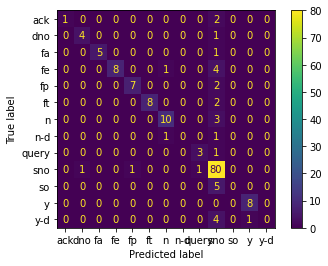

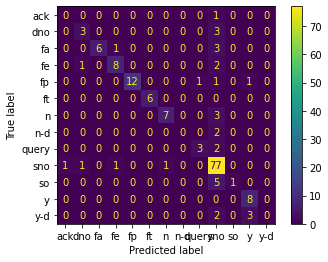

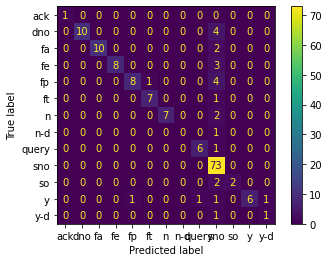

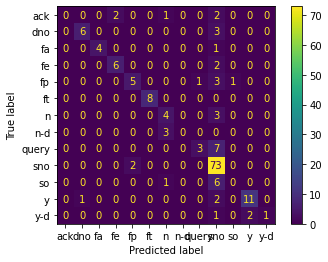

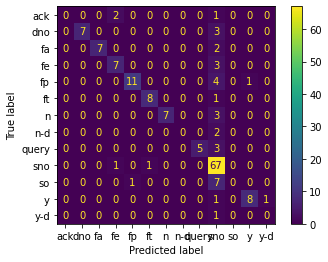

In [41]:
rf_models = []
rf_predictions =[]
rf_scores = []
rf_f1_scores = []
for i in range(len(data_train_encoded)):
    
    print("-------------------------------Model "+ str(i)+"--------------------------------")

    training_data = data_train_encoded[i]
    X_train = training_data[0]
    y_train = training_data[1]
    test_data = data_test_encoded[i]
    X_test = test_data[0]
    y_test = test_data[1]
    
    rf_clf = RandomForestClassifier(n_estimators=rf_best_params['n_estimators'],
                                    min_samples_split=rf_best_params['min_samples_split'],
                                    min_samples_leaf=rf_best_params['min_samples_leaf'], 
                                    max_features=rf_best_params["max_features"],
                                    max_depth=rf_best_params['max_depth'],
                                    bootstrap=rf_best_params['bootstrap'])

    rf_clf.fit(X_train, y_train)
    rf_models.append(rf_clf)
    #print()
    y_pred = rf_clf.predict(X_test)
    rf_predictions.append(y_pred)
    
    rf_scores.append(accuracy_score(y_test, y_pred))
    rf_f1_scores.append(f1_score(y_test, y_pred,average='macro'))
    print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred)))
    
    print("-------------------------------Model "+ str(i)+"--------------------------------")

    cm = confusion_matrix(le.inverse_transform(y_test), le.inverse_transform(y_pred))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot()
    

In [ ]:
sum(rf_scores)/5

In [ ]:
sum(rf_f1_scores)/5

In [ ]:
rf_scores

In [ ]:
rf_f1_scores


## Saving data 


In [552]:
#train model on all data

In [129]:
with open("Data/label_encoder.pkl", "wb") as f:
    pickle.dump(le,f)

In [554]:

with open("../FinalBERT/Data/label_encoder.pkl", "wb") as f:
    pickle.dump(le,f)

In [130]:
with open("Models/svm_models.pkl", "wb") as f:
    pickle.dump(models, f)

In [131]:
with open("Models/rf_models.pkl", "wb") as f:
    pickle.dump(rf_models, f)

In [132]:
with open("Data/data_5splits.pkl", "wb") as f:
    pickle.dump(list(zip(data_train_encoded, data_test_encoded)), f)

In [133]:
with open("Data/vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)